# test diffusion kernel

In [155]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from datetime import timedelta
from parcels import ParcelsRandom
from parcels import (FieldSet, ParticleSet, JITParticle,
                     DiffusionUniformKh, AdvectionDiffusionM1, AdvectionDiffusionEM,AdvectionRK4)

In [229]:
K_bar = 1   # Average diffusivity
alpha = 1.    # Profile steepness
L = 1.        # Basin scale
Ny = 103      # Number of grid cells in y_direction (101 +2, one level above and one below, where fields are set to zero)
dy = 1.03/Ny  # Spatial resolution
y = np.linspace(-90, 90, 103)  # y-coordinates for grid
y_K = np.linspace(0., 1., 101)     # y-coordinates used for setting diffusivity
beta = np.zeros(y_K.shape)         # Placeholder for fraction term in K(y) formula

for yi in range(len(y_K)):
    if y_K[yi] < L/2:
        beta[yi] = y_K[yi]*np.power(L - 2*y_K[yi], 1/alpha)
    elif y_K[yi] >= L/2:
        beta[yi] = (L - y_K[yi])*np.power(2*y_K[yi] - L, 1/alpha)
Kh_meridional = 0.1*(2*(1+alpha)*(1+2*alpha))/(alpha**2*np.power(L, 1+1/alpha))*beta * 10
Kh_meridional = np.concatenate((np.array([0]), Kh_meridional, np.array([0])))

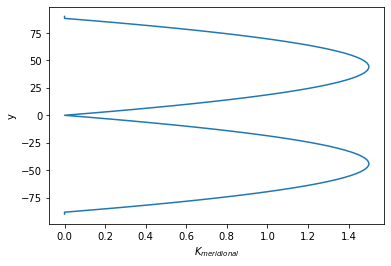

In [230]:
plt.plot(Kh_meridional, y)
plt.ylabel("y")
plt.xlabel(r"$K_{meridional}$")
plt.show()

In [231]:
xdim, ydim = (1, Ny)
data = {'U': np.zeros(ydim),
        'V': np.zeros(ydim),
        'Kh_zonal': K_bar*np.ones(ydim),
        'Kh_meridional':  K_bar*np.ones(ydim)}#Kh_meridional}
dims = {'lon': 1,
        'lat': np.linspace(-90, 90, ydim, dtype=np.float32)}
fieldset = FieldSet.from_data(data, dims, mesh='spherical', allow_time_extrapolation=True)
fieldset.add_constant('dres', 0.00005)

In [239]:
def get_test_particles():
    return ParticleSet.from_list(fieldset,
                                 pclass=JITParticle,
                                 lon=np.zeros(100),
                                 lat=np.ones(100)*45,
                                 time=np.zeros(100),
                                 lonlatdepth_dtype=np.float64)

In [240]:
seconds_per_day = 24 * 60 * 60
dt = 0.25 * seconds_per_day
testParticles = get_test_particles()
output_file = testParticles.ParticleFile(name="M1_out.nc",
                                         outputdt=timedelta(seconds=dt))
ParcelsRandom.seed(1636)  # Random seed for reproducibility

kernels = testParticles.Kernel(AdvectionRK4) + testParticles.Kernel(DiffusionUniformKh)

testParticles.execute(kernels,
                      runtime=timedelta(days=365),
                      dt=timedelta(seconds=dt),
                      output_file=output_file,
                      verbose_progress=True)

output_file.close()

INFO: Compiled ArrayJITParticleAdvectionRK4DiffusionUniformKh ==> /tmp/parcels-1043/lib63e5ab1b3bbf0b2c5afaaef6364108e0_0.so
100% (31536000.0 of 31536000.0) |########| Elapsed Time: 0:00:56 Time:  0:00:56


In [242]:
import parcels.rng as ParcelsRandom
import math

def BrownianMotion2D(particle, fieldset, time):
    """
    Kernel for simple Brownian particle diffusion in zonal and meridional direction.
    Assumes that fieldset has fields Kh_zonal and Kh_meridional
    """
    r = 1 / 3.
    kh_meridional = fieldset.Kh_meridional[time, particle.depth, particle.lat, particle.lon]
    particle.lat += ParcelsRandom.uniform(-1, 1) * math.sqrt(2 * math.fabs(particle.dt) * kh_meridional / r)
    kh_zonal = fieldset.Kh_zonal[time, particle.depth, particle.lat, particle.lon]
    particle.lon += ParcelsRandom.uniform(-1, 1) * math.sqrt(2 * math.fabs(particle.dt) * kh_zonal / r)
    
testParticles = get_test_particles()
output_file = testParticles.ParticleFile(name="M2_out.nc",
                                         outputdt=timedelta(seconds=dt))
ParcelsRandom.seed(1636)  # Random seed for reproducibility

kernels = testParticles.Kernel(AdvectionRK4) + testParticles.Kernel(BrownianMotion2D)

testParticles.execute(kernels,
                      runtime=timedelta(days=365),
                      dt=timedelta(seconds=dt),
                      output_file=output_file,
                      verbose_progress=True)

output_file.close()

INFO: Compiled ArrayJITParticleAdvectionRK4BrownianMotion2D ==> /tmp/parcels-1043/libbb19254c7dfbcc2bf33d1caa9dd3c2e5_0.so
100% (31536000.0 of 31536000.0) |########| Elapsed Time: 0:00:19 Time:  0:00:19


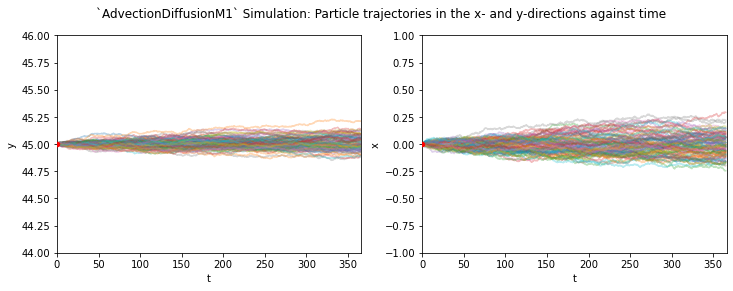

In [243]:
M1_out = xr.open_dataset("M1_out.nc")

fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)

for data, ai, dim, ystart, ylim in zip([M1_out.lat, M1_out.lon], ax, ('y', 'x'), (45, 0), [(44, 46), (-1, 1)]):
    ai.plot(np.arange(0, 365.25, 0.25), data.T, alpha=0.3)
    ai.scatter(0, ystart, s=20, c='r', zorder=3)
    ai.set_ylim(ylim)
    ai.set_ylabel(dim)
    ai.set_xlabel("t")
    ai.set_xlim(0, 366)

fig.suptitle("`AdvectionDiffusionM1` Simulation: Particle trajectories in the x- and y-directions against time")
plt.show()

M1_out.close()

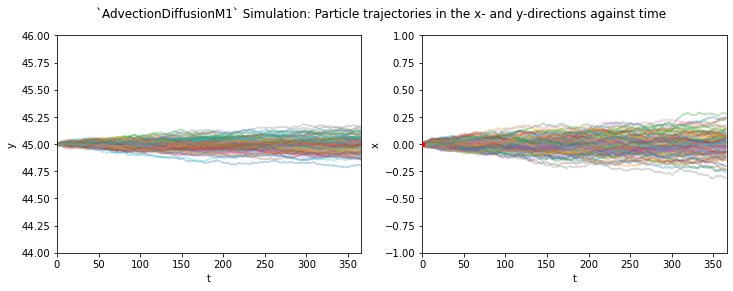

In [244]:
M1_out = xr.open_dataset("M2_out.nc")

fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)

for data, ai, dim, ystart, ylim in zip([M1_out.lat, M1_out.lon], ax, ('y', 'x'), (0.75, 0), [(44, 46), (-1, 1)]):
    ai.plot(np.arange(0, 365.25, 0.25), data.T, alpha=0.3)
    ai.scatter(0, ystart, s=20, c='r', zorder=3)
    ai.set_xlabel("t")
    ai.set_ylabel(dim)
    ai.set_xlim(0, 366)
    ai.set_ylim(ylim)

fig.suptitle("`AdvectionDiffusionM1` Simulation: Particle trajectories in the x- and y-directions against time")
plt.show()

M1_out.close()